# House price prediction (linear regression)
### Author: Dominik Kurowski
***

### Table of Contents:
#### 1. [Data cleaning and dimensionality reduction](#title1)
#### 2. [Analysis of relationships between features](#title2)
#### 3. [Building linear regression model](#title3)

<br>
In this notebook I will guide you through the subsequent stages of the dataset analysis and creation of linear regression model. I will try to answer the question what is the price of given house, based on its characteristics.

<br><br>
**Dataset source:** https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

## Importing libraries
***

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

<a id='title1'></a>
## Data cleaning and dimensionality reduction
***
### 1. Loading the dataset

In [2]:
data = pd.read_csv('./data/houses.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### 2. Showing the correlation between features

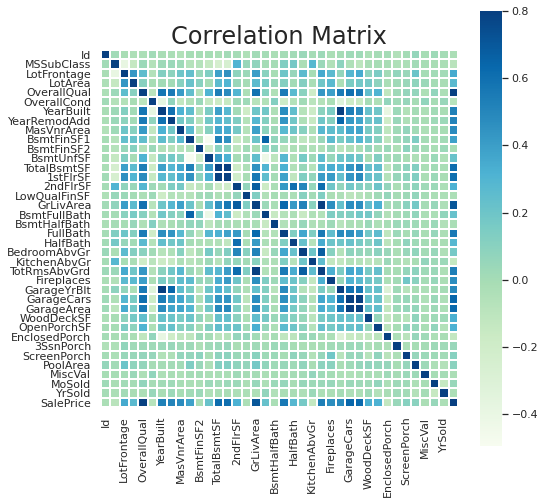

In [3]:
sns.set(style="whitegrid", font_scale=1)

plt.figure(figsize=(8,8))
plt.title('Correlation Matrix',fontsize=24)
sns.heatmap(data.corr(), linewidths=0.1, vmax=0.8, square=True, cmap="GnBu",
    linecolor='w', annot=False)
plt.show()

### 3. Reducing the redundant amount of data

In [4]:
price_corr = data.corr()['SalePrice'].sort_values(ascending=False)
important_keys = price_corr[price_corr > 0.5].keys()
important_keys = important_keys.drop(['1stFlrSF', 'GarageCars', 'OverallQual', 'TotRmsAbvGrd'])
print(important_keys)

Index(['SalePrice', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath',
       'YearBuilt', 'YearRemodAdd'],
      dtype='object')


In [5]:
keys_to_remove = data.keys().difference(important_keys)
data = data.drop(labels=keys_to_remove, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   YearBuilt     1460 non-null   int64
 1   YearRemodAdd  1460 non-null   int64
 2   TotalBsmtSF   1460 non-null   int64
 3   GrLivArea     1460 non-null   int64
 4   FullBath      1460 non-null   int64
 5   GarageArea    1460 non-null   int64
 6   SalePrice     1460 non-null   int64
dtypes: int64(7)
memory usage: 80.0 KB


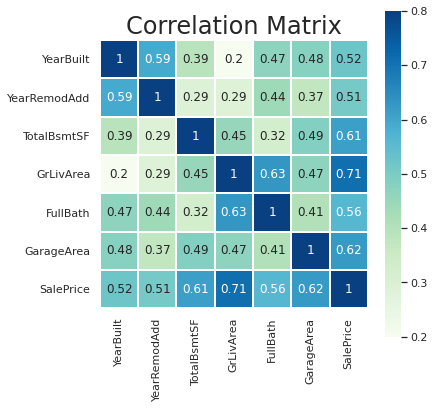

In [6]:
sns.set(style="whitegrid", font_scale=1)

plt.figure(figsize=(6,6))
plt.title('Correlation Matrix',fontsize=24)
sns.heatmap(data.corr(), linewidths=0.1, vmax=0.8, square=True, cmap="GnBu",
    linecolor='w', annot=True)
plt.show()

### 4. Cleaning the column names

In [7]:
new_columns_names = {'YearRemodAdd': 'YearRenovated',
                     'TotalBsmtSF' : 'BasementArea',
                     'GrLivArea'   : 'LivingArea',
                     'FullBath'    : 'Bathrooms',
                     'SalePrice'   : 'Price'}
data = data.rename(columns=new_columns_names)

### 5. Convertion from square feet to square meters

In [8]:
for key in ('BasementArea', 'LivingArea', 'GarageArea'):
    data[key] = data[key].apply(lambda x: round(x / 10.764, 2))

<a id='title2'></a>
## Analysis of relationships between features
***
### 1. Basic dataset description

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
YearBuilt,1460.0,1971.267808,30.202904,1872.00,1954.0000,1973.000,2000.0000,2010.00
YearRenovated,1460.0,1984.865753,20.645407,1950.00,1967.0000,1994.000,2004.0000,2010.00
BasementArea,1460.0,98.237610,40.756735,0.00,73.9275,92.115,120.6125,567.63
LivingArea,1460.0,140.790007,48.818286,31.03,104.9325,136.010,165.0600,524.15
Bathrooms,1460.0,1.565068,0.550916,0.00,1.0000,2.000,2.0000,3.00
GarageArea,1460.0,43.940973,19.862824,0.00,31.0800,44.590,53.5100,131.74
Price,1460.0,180921.195890,79442.502883,34900.00,129975.0000,163000.000,214000.0000,755000.00


### 2. Plotting price distribution

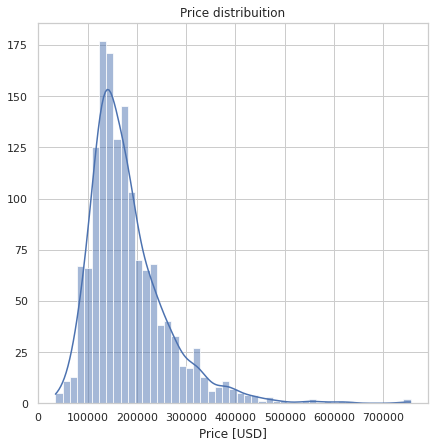

In [10]:
f, ax = plt.subplots(figsize=(7,7))

sns.histplot(data['Price'], kde=True)
ax.set(xlabel='Price [USD]', ylabel='', title='Price distribuition')

plt.show()

### 3. Plotting relationships between features

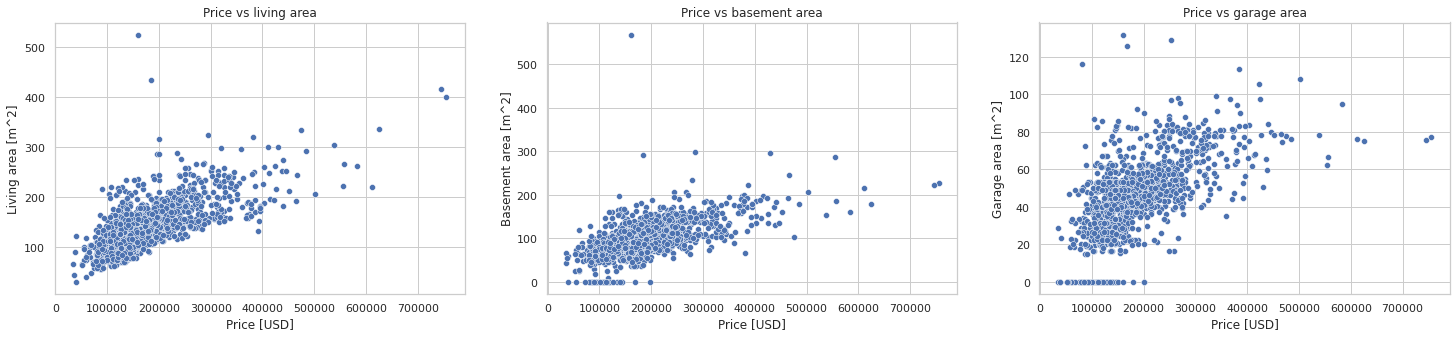

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(25,5))
sns.scatterplot(x='Price',y='LivingArea'  , data=data, ax=ax[0])
sns.scatterplot(x='Price',y='BasementArea', data=data, ax=ax[1])
sns.scatterplot(x='Price',y='GarageArea'  , data=data, ax=ax[2])
ax[0].set(xlabel='Price [USD]', ylabel='Living area [m^2]', title='Price vs living area')
ax[1].set(xlabel='Price [USD]', ylabel='Basement area [m^2]', title='Price vs basement area')
ax[2].set(xlabel='Price [USD]', ylabel='Garage area [m^2]', title='Price vs garage area')
plt.show()

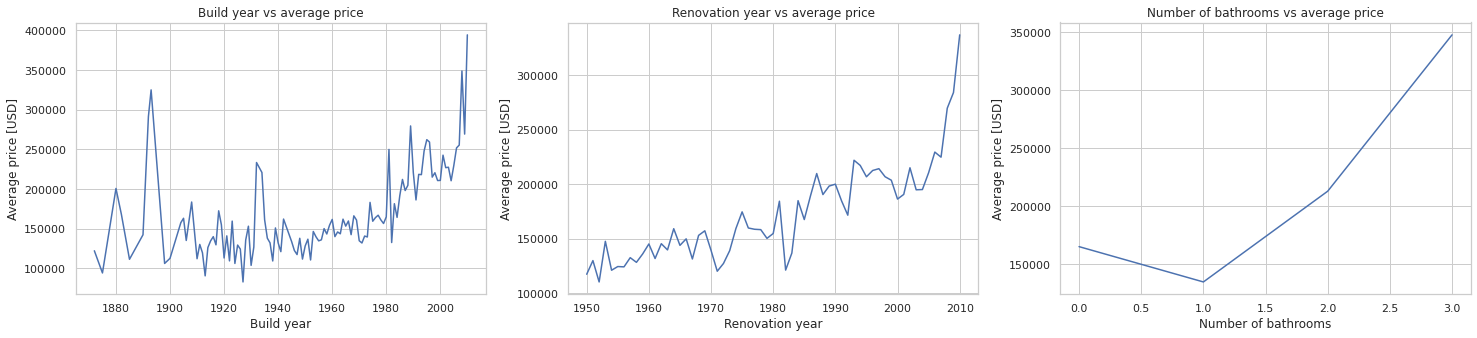

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(25,5))
plt_data = data[['YearBuilt', 'Price']].groupby(data['YearBuilt']).mean()
ax[0].plot(plt_data['YearBuilt'], plt_data['Price'])
ax[0].set(xlabel='Build year', ylabel='Average price [USD]', title='Build year vs average price')
plt_data = data[['YearRenovated', 'Price']].groupby(data['YearRenovated']).mean()
ax[1].plot(plt_data['YearRenovated'], plt_data['Price'])
ax[1].set(xlabel='Renovation year', ylabel='Average price [USD]', title='Renovation year vs average price')
plt_data = data[['Bathrooms', 'Price']].groupby(data['Bathrooms']).mean()
ax[2].plot(plt_data['Bathrooms'], plt_data['Price'])
ax[2].set(xlabel='Number of bathrooms', ylabel='Average price [USD]', title='Number of bathrooms vs average price')
plt.show()

<a id='title3'></a>
## Building linear regression model
***
### 1. Split data between training and test sets

In [13]:
x = data.drop(['Price', 'YearBuilt'], axis=1)
y = data['Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### 2. Build the linear regression model

In [14]:
x_train.shape, y_train.shape

((1168, 5), (1168,))

In [15]:
x_test.shape, y_test.shape

((292, 5), (292,))

In [16]:
model = linear_model.LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

### 3. Properties of the trained predictive model

In [17]:
print('Coefficients:', model.coef_)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Mean absolute error: %.2f' % mean_absolute_error(y_test, y_pred))
print('Coefficient of deterination (R^2): %.2f' % r2_score(y_test, y_pred))

Coefficients: [772.63417509 621.98021115 767.16862122 195.23110302 807.84513101]
Mean squared error: 3779185128.62
Mean absolute error: 31793.65
Coefficient of deterination (R^2): 0.45


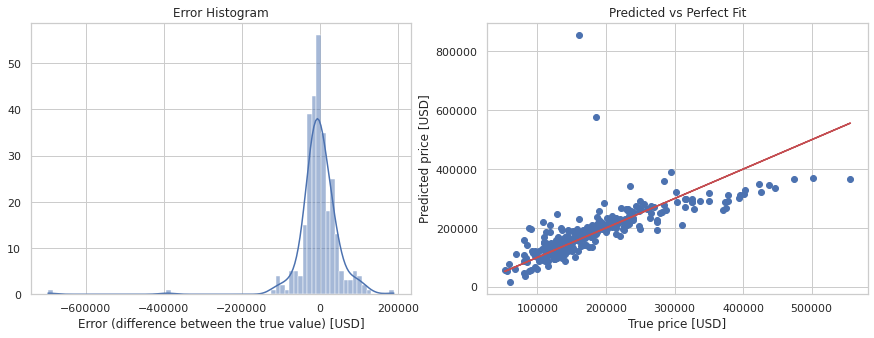

In [18]:
f, ax = plt.subplots(1, 2, figsize=(15,5))

errors = (y_test - y_pred)
sns.histplot(errors, kde=True, ax=ax[0])
ax[0].set(xlabel='Error (difference between the true value) [USD]', ylabel='', title='Error Histogram')

plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test,'r')
ax[1].set(xlabel='True price [USD]', ylabel='Predicted price [USD]', title='Predicted vs Perfect Fit')

plt.show()

#### Thank You for taking the time to read this notebook. I hope You found it informative.

